In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_train = pd.read_csv("./train.csv/train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("./test.csv/test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("./macro.csv", parse_dates=['timestamp'])

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# =============================
# =============================
# cleanup
# brings error down a lot by removing extreme price per sqm
print(df_train.shape)
df_train.loc[df_train.full_sq == 0, 'full_sq'] = 30
df_train = df_train[df_train.price_doc/df_train.full_sq <= 600000]
df_train = df_train[df_train.price_doc/df_train.full_sq >= 10000]
print(df_train.shape)
#print df_train.describe()
# =============================
# =============================


#==============================
y_train =df_train['price_doc'].values
Y = np.log(df_train["price_doc"].values)
id_test = df_test['id']

df_train.drop(['id', 'price_doc'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)
#=============================

(30471, 292)
(30404, 292)


In [3]:
# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
print df_all.shape
print df_all.columns
df_all = df_all.join(df_macro, on='timestamp', rsuffix='_macro')
print(df_all.shape)
print df_all.columns
# ==============================

# Add month-year
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)
#df_all["FAR"]=df_all["full_sq"]/df_all["area_m"].astype(float)
#df_all["ratio_life"]=((df_all["full_sq"]-df_all["kitch_sq"])/df_all["life_sq"]).astype(float)
df_all["inverse_floor"] = df_all["max_floor"]-df_all["floor"]
df_all["extra_area"] = df_all["full_sq"] - df_all["life_sq"]
df_all["room_size"] = (df_all["life_sq"] - df_all["kitch_sq"])/df_all["num_room"]
df_all["pop_density_raion"] = df_all["raion_popul"]/df_all["area_m"]
df_all["young_proportion"] =df_all["young_all"] / df_all["full_all"]
df_all["work_proportion"] = df_all["work_all"] / df_all["full_all"]
df_all["retire_proportion"] = df_all["ekder_all"] / df_all["full_all"]
df_all["ratio_preschool"] = df_all["children_school"] /df_all["preschool_quota"]
df_all["ratio_school"] = df_all["children_school"] / df_all["school_quota"]


#df_all["sqrt_area"] = np.sqrt(df_all["area_m"])
#df_all["log_full_sq"] = np.log(df_all["full_sq"])
#df_all["log_life_sq"] = np.log(df_all["life_sq"])
#df_all["log_kitch_sq"] = np.log(df_all["kitch_sq"])
#df_all["log_area_m"] = np.log(df_all["area_m"])
#df_all.drop(['full_sq','life_sq','kitch_sq','area_m'],axis=1,inplace=True)
#print df_all.loc[:,["sub_area","full_sq","life_sq","sqrt_area","area_m"]]

#df_all["st_mate"] = df_all["state"]*df_all["material"]

(38066, 290)
Index([u'timestamp', u'full_sq', u'life_sq', u'floor', u'max_floor',
       u'material', u'build_year', u'num_room', u'kitch_sq', u'state',
       ...
       u'cafe_count_5000_price_1500', u'cafe_count_5000_price_2500',
       u'cafe_count_5000_price_4000', u'cafe_count_5000_price_high',
       u'big_church_count_5000', u'church_count_5000', u'mosque_count_5000',
       u'leisure_count_5000', u'sport_count_5000', u'market_count_5000'],
      dtype='object', length=290)
(38066, 390)
Index([u'timestamp', u'full_sq', u'life_sq', u'floor', u'max_floor',
       u'material', u'build_year', u'num_room', u'kitch_sq', u'state',
       ...
       u'provision_retail_space_modern_sqm', u'turnover_catering_per_cap',
       u'theaters_viewers_per_1000_cap',
       u'seats_theather_rfmin_per_100000_cap', u'museum_visitis_per_100_cap',
       u'bandwidth_sports', u'population_reg_sports_share',
       u'students_reg_sports_share', u'apartment_build',
       u'apartment_fund_sqm'],
      d

In [4]:
#clean build_year
col = "build_year"
df_all[col].fillna(0,inplace=True)

df_all["build_year"] = df_all[df_all.build_year.values > 0]
ulimit = np.percentile(df_all[col].values, 99.995)
#llimit = np.percentile(df_all[col].values, 0.005)
df_all[col].ix[df_all[col]>ulimit] = ulimit
#df_all[col].ix[df_all[col]<llimit] = llimit


/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(38066, 403)
(38066, 403)
[0]	train-rmse:8.19435e+06	test-rmse:8.19944e+06
[1]	train-rmse:7.83736e+06	test-rmse:7.85046e+06
[2]	train-rmse:7.50098e+06	test-rmse:7.51954e+06
[3]	train-rmse:7.184e+06	test-rmse:7.20724e+06
[4]	train-rmse:6.89083e+06	test-rmse:6.92151e+06
[5]	train-rmse:6.61005e+06	test-rmse:6.64875e+06
[6]	train-rmse:6.33965e+06	test-rmse:6.38354e+06
[7]	train-rmse:6.09071e+06	test-rmse:6.14106e+06
[8]	train-rmse:5.85041e+06	test-rmse:5.90791e+06
[9]	train-rmse:5.6292e+06	test-rmse:5.6944e+06
[10]	train-rmse:5.41652e+06	test-rmse:5.49162e+06
[11]	train-rmse:5.21437e+06	test-rmse:5.29802e+06
[12]	train-rmse:5.0268e+06	test-rmse:5.11817e+06
[13]	train-rmse:4.85504e+06	test-rmse:4.95317e+06
[14]	train-rmse:4.69056e+06	test-rmse:4.79851e+06
[15]	train-rmse:4.53338e+06	test-rmse:4.65021e+06
[16]	train-rmse:4.3838e+06	test-rmse:4.51128e+06
[17]	train-rmse:4.24332e+06	test-rmse:4.37704e+06
[18]	train-rmse:4.11465e+06	test-rmse:4.25762e+06
[19]	train-rmse:3.99147e+06	test-rmse:4.

[163]	train-rmse:1.97832e+06	test-rmse:2.6093e+06
[164]	train-rmse:1.9767e+06	test-rmse:2.60896e+06
[165]	train-rmse:1.97513e+06	test-rmse:2.60826e+06
[166]	train-rmse:1.97307e+06	test-rmse:2.6076e+06
[167]	train-rmse:1.9712e+06	test-rmse:2.60697e+06
[168]	train-rmse:1.96911e+06	test-rmse:2.60708e+06
[169]	train-rmse:1.96713e+06	test-rmse:2.60623e+06
[170]	train-rmse:1.96529e+06	test-rmse:2.60579e+06
[171]	train-rmse:1.96396e+06	test-rmse:2.60529e+06
[172]	train-rmse:1.96236e+06	test-rmse:2.60515e+06
[173]	train-rmse:1.96084e+06	test-rmse:2.60522e+06
[174]	train-rmse:1.95933e+06	test-rmse:2.60486e+06
[175]	train-rmse:1.9576e+06	test-rmse:2.60398e+06
[176]	train-rmse:1.9555e+06	test-rmse:2.60377e+06
[177]	train-rmse:1.95366e+06	test-rmse:2.60353e+06
[178]	train-rmse:1.95216e+06	test-rmse:2.60322e+06
[179]	train-rmse:1.95112e+06	test-rmse:2.60313e+06
[180]	train-rmse:1.95023e+06	test-rmse:2.60314e+06
[181]	train-rmse:1.9482e+06	test-rmse:2.60272e+06
[182]	train-rmse:1.94663e+06	test-rmse

[325]	train-rmse:1.7574e+06	test-rmse:2.58042e+06
[326]	train-rmse:1.75617e+06	test-rmse:2.58035e+06
[327]	train-rmse:1.75475e+06	test-rmse:2.58033e+06
[328]	train-rmse:1.75366e+06	test-rmse:2.58008e+06
[329]	train-rmse:1.75272e+06	test-rmse:2.58013e+06
[330]	train-rmse:1.75198e+06	test-rmse:2.58046e+06
[331]	train-rmse:1.75136e+06	test-rmse:2.58033e+06
[332]	train-rmse:1.75028e+06	test-rmse:2.58018e+06
[333]	train-rmse:1.74935e+06	test-rmse:2.58007e+06
[334]	train-rmse:1.74838e+06	test-rmse:2.57985e+06
[335]	train-rmse:1.74738e+06	test-rmse:2.57969e+06
[336]	train-rmse:1.74637e+06	test-rmse:2.57964e+06
[337]	train-rmse:1.74505e+06	test-rmse:2.57959e+06
[338]	train-rmse:1.74402e+06	test-rmse:2.57952e+06
[339]	train-rmse:1.74255e+06	test-rmse:2.57955e+06
[340]	train-rmse:1.74143e+06	test-rmse:2.57968e+06
[341]	train-rmse:1.74015e+06	test-rmse:2.57939e+06
[342]	train-rmse:1.7392e+06	test-rmse:2.57941e+06
[343]	train-rmse:1.7379e+06	test-rmse:2.57936e+06
[344]	train-rmse:1.73707e+06	test-

[487]	train-rmse:1.59907e+06	test-rmse:2.57334e+06
[488]	train-rmse:1.59846e+06	test-rmse:2.57315e+06
[489]	train-rmse:1.59768e+06	test-rmse:2.57329e+06
[490]	train-rmse:1.59659e+06	test-rmse:2.57306e+06
[491]	train-rmse:1.59576e+06	test-rmse:2.57311e+06
[492]	train-rmse:1.595e+06	test-rmse:2.57315e+06
[493]	train-rmse:1.59403e+06	test-rmse:2.57305e+06
[494]	train-rmse:1.59308e+06	test-rmse:2.57324e+06
[495]	train-rmse:1.59215e+06	test-rmse:2.57311e+06
[496]	train-rmse:1.59153e+06	test-rmse:2.57323e+06
[497]	train-rmse:1.59075e+06	test-rmse:2.57324e+06
[498]	train-rmse:1.58995e+06	test-rmse:2.57327e+06
[499]	train-rmse:1.58937e+06	test-rmse:2.57335e+06
[500]	train-rmse:1.5888e+06	test-rmse:2.57344e+06
[501]	train-rmse:1.58768e+06	test-rmse:2.57363e+06
[502]	train-rmse:1.58706e+06	test-rmse:2.57359e+06
[503]	train-rmse:1.58605e+06	test-rmse:2.57368e+06
[504]	train-rmse:1.58525e+06	test-rmse:2.57371e+06
[505]	train-rmse:1.58454e+06	test-rmse:2.57365e+06
[506]	train-rmse:1.58354e+06	test-

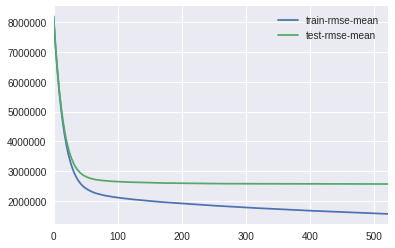

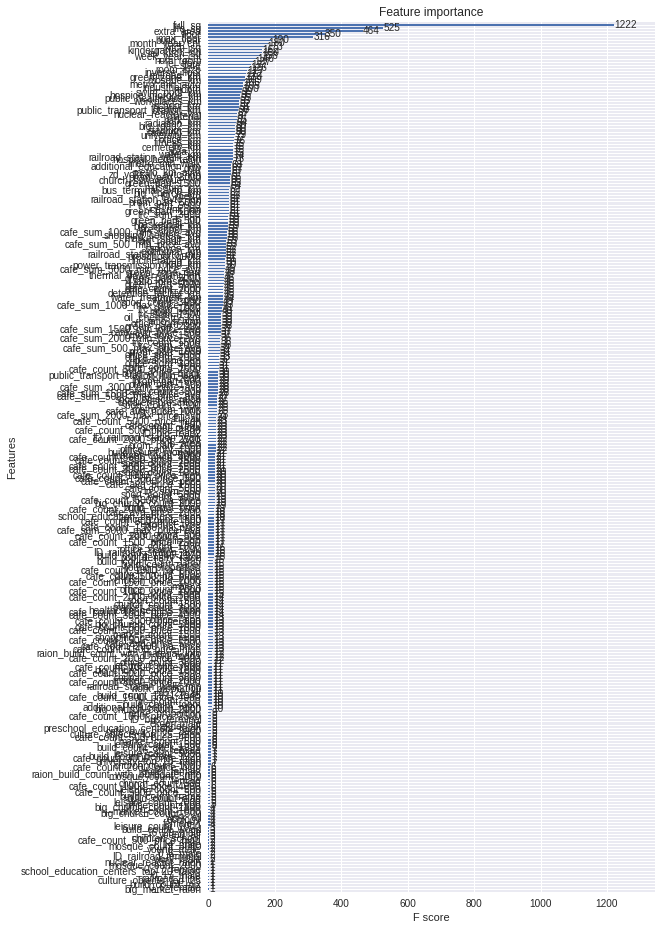

In [5]:
#df_all["build_year"].describe()

#print df_all.loc[:,["build_count_before_1920","build_count_1921-1945","build_count_1946-1970","build_count_1971-1995","build_count_after_1995"]]

#df_all.loc[:,["timestamp","sub_area","raion_build_count_with_builddate_info","build_count_before_1920","build_count_1921-1945", "build_count_1946-1970","build_count_1971-1995","build_count_after_1995","build_year"]]

#df_all["room_area"] = ((df_all["life_sq"] - df_all["kitch_sq"])/df_all["num_room"]).astype(float)

#df_all.loc[:,["sub_area","raion_popul"]]

#df_all["raion_build_count_with_builddate_info"].describe([0.01,0.99])

# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp', 'timestamp_macro'], axis=1, inplace=True)

factorize = lambda t: pd.factorize(t[1])[0]

df_obj = df_all.select_dtypes(include=['object'])

X_all = np.c_[
    df_all.select_dtypes(exclude=['object']).values,
    np.array(list(map(factorize, df_obj.iteritems()))).T
]
print(X_all.shape)

X_train = X_all[:num_train]
X_test = X_all[num_train:]


# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)


# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

X_train = X_all[:num_train]
X_test = X_all[num_train:]

df_columns = df_values.columns


xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
    #'alpha':0.001
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)


# Uncomment to tune XGB `num_boost_rounds`

cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=True, show_stdv=False)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
num_boost_rounds = len(cv_result)

num_boost_round = 500

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_round)

fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model,height=0.5, ax=ax)
plt.show()

y_pred = model.predict(dtest)
y_pred = np.round(y_pred)
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})


df_sub.to_csv('sub_529_6.csv', index=False)

In [6]:
print df_sub

         id   price_doc
0     30474   5061250.0
1     30475   8073855.0
2     30476   5422419.0
3     30477   5638600.0
4     30478   4757654.0
5     30479   8779448.0
6     30480   4224634.0
7     30481   4328040.0
8     30482   4429022.0
9     30483   4762364.0
10    30484   6469018.0
11    30485   4676696.0
12    30486   3577542.0
13    30487   3844744.0
14    30488   6253804.0
15    30489   6105210.0
16    30490  23868002.0
17    30491  18845808.0
18    30492   5599801.0
19    30493  12738810.0
20    30494   6694174.0
21    30495  10227406.0
22    30496   8777680.0
23    30497   8578364.0
24    30498   4113805.0
25    30499   7520514.0
26    30500  11410816.0
27    30501   6910256.0
28    30502   2944368.0
29    30503   5875778.0
...     ...         ...
7632  38106   6066109.0
7633  38107   2939556.0
7634  38108  11044432.0
7635  38109   4681457.0
7636  38110   3587126.0
7637  38111   4623252.0
7638  38112   3158668.0
7639  38113   7142988.0
7640  38114   5288286.0
7641  38115   31